<div align="center">

### Lab 4

# National Tsing Hua University

#### Spring 2025

#### 11320IEEM 513600

#### Deep Learning and Industrial Applications
    
## Lab 4: Predicting Stock Price with Deep Learning

</div>

### Introduction

In this lab, we explore the application of time-series datasets using Long Short-Term Memory (LSTM) networks, a type of recurrent neural network, to predict stock prices. Specifically, we will use historical price data from Nvidia to forecast the stock's price for the next day based on the prices of the previous N days. This approach is particularly relevant given the volatile nature of stock markets and the increasing reliance on automated trading systems.

### Objectives

- To understand the fundamentals of LSTM networks and their application in time-series forecasting.
- To develop a predictive model that can accurately forecast Nvidia's stock price for the next day using historical data.

### Dataset

The dataset for this lab is from the "Huge Stock Market Dataset" available on Kaggle. This dataset includes daily prices and volumes for all US stocks and ETFs, with a specific focus on Nvidia (NVDA). The dataset features include:

- **Date**: The recorded data points.
- **Open**: The price at which the stock first traded upon the opening of an exchange on a given trading day.
- **High**: The highest price at which the stock traded during the trading day.
- **Low**: The lowest price at which the stock traded during the trading day.
- **Close**: The price of the stock at closing time.
- **Volume**: The number of shares or contracts traded in a security or an entire market during a given period.
- **OpenInt**: The total number of outstanding derivative contracts, like options or futures. [More details here](https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs/discussion/121096)

### References

- [Huge Stock Market Dataset](https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs) for the dataset used in this lab.


# (1) 僅保留 Scenario 1 的實驗結果

## A. Checking and Preprocessing

In [ ]:
import nbformat
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DL_1132/HW4/HW4/nvda.us.txt')
df

,Date,Open,High,Low,Close,Volume,OpenInt
0,1999-01-22,1.6238,1.8092,1.4379,1.5215,18297633,0
1,1999-01-25,1.6423,1.6980,1.5215,1.6793,3445279,0
2,1999-01-26,1.6980,1.7350,1.5311,1.5494,2320993,0
3,1999-01-27,1.5586,1.5957,1.4660,1.5494,1662658,0
4,1999-01-28,1.5494,1.5586,1.5311,1.5401,1540110,0
...,...,...,...,...,...,...,...
4728,2017-11-06,207.2000,209.9800,206.7000,209.6300,9731783,0
4729,2017-11-07,210.5500,212.9000,210.0560,212.0000,10671815,0
4730,2017-11-08,211.8500,212.0000,207.2400,209.1600,13033902,0
4731,2017-11-09,205.2700,206.3300,200.3700,205.3200,23895006,0


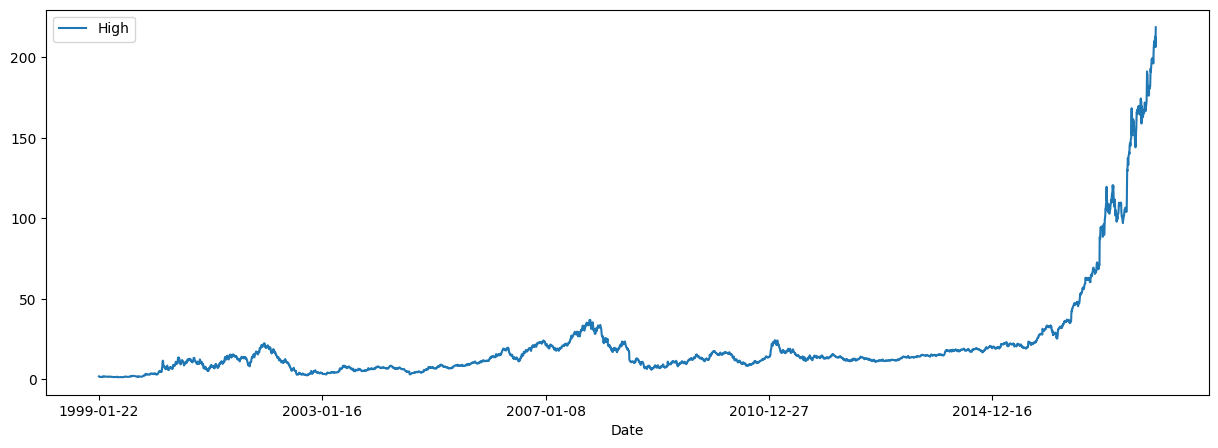

In [ ]:
plot = df.plot('Date', 'High', figsize=(15, 5))

In [ ]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt'], dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4733 entries, 0 to 4732
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     4733 non-null   object 
 1   Open     4733 non-null   float64
 2   High     4733 non-null   float64
 3   Low      4733 non-null   float64
 4   Close    4733 non-null   float64
 5   Volume   4733 non-null   int64  
 6   OpenInt  4733 non-null   int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 259.0+ KB


In [ ]:
# checking for null values
df.isnull().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Volume,0
OpenInt,0


In [ ]:
df = df.dropna()

In [ ]:
df.shape

(4733, 7)

In [ ]:
df.describe()

,Open,High,Low,Close,Volume,OpenInt
count,4733.000000,4733.000000,4733.000000,4733.000000,4.733000e+03,4733.0
mean,20.796242,21.157332,20.420417,20.805404,1.615287e+07,0.0
std,30.236284,30.615622,29.792958,30.263705,1.272446e+07,0.0
min,1.298900,1.317500,1.233900,1.261900,0.000000e+00,0.0
25%,7.988300,8.247900,7.756400,7.978900,8.181100e+06,0.0
50%,12.963000,13.238000,12.721000,12.990000,1.390271e+07,0.0
75%,19.141000,19.418000,18.778000,19.106000,2.051602e+07,0.0
max,213.080000,218.670000,211.630000,216.140000,2.496659e+08,0.0


#### Converting the DataFrame to a NumPy Array

In [ ]:
# 建立時間序列的資料切片 (將原始表格資料切割成 LSTM 可以接受的序列格式)
def create_sequences(input_data, output_data, window_size, step): # window_size: 每筆輸入的時間長度（例如過去10天）; step: window每次滑動的步幅; input_data：特徵資料，例如 Open/High/Low/Close 等;output_data：標籤資料，這裡是下一天的 High
    sequences = []
    labels = []
    # 使用滑動視窗（sliding window）切割資料
    for i in range(0, len(input_data) - window_size, step):
        sequences.append(input_data[i:(i + window_size)]) # 從第 i 天開始，擷取連續 window_size 天的特徵資料當作一筆輸入
        labels.append(output_data[i + window_size]) # 第 i + window_size 天的 output_data 為該筆資料的標籤（預測目標）
    return np.array(sequences), np.array(labels)

In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# 特徵選擇與資料切割
features = df[['Open', 'High', 'Low', 'Close']]
labels = df['High'].shift(-1) # shift(-1) 將 High 欄位往上平移一格
X, y = create_sequences(features, labels, window_size=10, step=5) # 將資料轉換為 LSTM 所需的序列格式。

print(f'Shape of data X: {X.shape}')
print(f'Shape of data y: {y.shape}')

# 切出測試集 split the hold-out tests
ind = np.linspace(0, len(X)-1, num=int(len(X)*0.1), dtype=int) # 使用等間距方式，從資料中選出 10% 當作測試集(hold-out)的索引
x_test = X[ind]
y_test = y[ind]
all_ind = np.arange(len(X))
remains_ind = np.delete(all_ind, ind) # 建立全體索引，再移除測試資料的索引，留下其餘作為 train/val

# X 與 y 變成「剩餘資料」
X = X[remains_ind]
y = y[remains_ind]

# 打亂資料，切分訓練與驗證集（Train 80% / Val 20%） shuffle dataset
ind = np.random.permutation(len(X))
X = X[ind]
y = y[ind]
split_point = int(X.shape[0]*0.8)

x_train = X[:split_point]
y_train = y[:split_point]
x_val = X[split_point:]
y_val = y[split_point:]

# 輸出所有子集的 shape，確保切割正確
print(f'Shape of data x_train: {x_train.shape}')
print(f'Shape of data y_train: {y_train.shape}')
print(f'Shape of data x_val: {x_val.shape}')
print(f'Shape of data y_val: {y_val.shape}')
print(f'Shape of data x_test: {x_test.shape}')
print(f'Shape of data y_test: {y_test.shape}')

# 將所有 numpy 陣列轉為 PyTorch Tensor 格式，並轉換為 float
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()

x_val = torch.from_numpy(x_val).float()
y_val = torch.from_numpy(y_val).float()

x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).float()

batch_size = 32

# 建立 Dataset 與 DataLoader
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
test_dataset = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f'Number of samples in training and validation are {len(train_loader.dataset)} and {len(val_loader.dataset)}.')

Shape of data X: (945, 10, 4)
Shape of data y: (945,)
Shape of data x_train: (680, 10, 4)
Shape of data y_train: (680,)
Shape of data x_val: (171, 10, 4)
Shape of data y_val: (171,)
Shape of data x_test: (94, 10, 4)
Shape of data y_test: (94,)
Number of samples in training and validation are 680 and 171.


## B. Defining Neural Networks

In [ ]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim # LSTM 隱藏層的維度
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True) # LSTM 模組
        self.fc = nn.Linear(hidden_dim, output_dim) # 線性層：將最後一層 LSTM 輸出轉為最終預測

    def forward(self, x):
        out, _ = self.lstm(x) # 將輸入 x 傳入 LSTM，得到時間序列的所有輸出
        out = self.fc(out[:, -1, :]) # 取最後一個時間步的輸出作為預測依據，接上線性層
        return out

## C. Training the Neural Network

In [ ]:
# Check your GPU status.
!nvidia-smi

Wed Apr 30 17:55:03 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   77C    P0             36W /   70W |     368MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm.auto import tqdm

train_losses = []
val_losses = []

epochs = 100

model = LSTMModel(input_dim=4, hidden_dim=500, num_layers=2, output_dim=1).cuda()
print(model)

best_val_loss = float('inf')

criterion = nn.MSELoss() # 定義損失函數為 MSE
optimizer = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0) # 餘弦學習率衰減調整器

for epoch in tqdm(range(epochs)):
    # Training
    model.train()
    total_loss = 0.0

    for features, labels in train_loader:
        features = features.cuda()
        labels = labels.cuda()
        outputs = model(features).squeeze(-1)
        loss = criterion(outputs, labels)
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Learning rate update
    lr_scheduler.step()

    avg_train_loss = total_loss / len(train_loader)

    # Validation
    model.eval()
    total_val_loss = 0.0

    with torch.no_grad(): # 驗證過程不計算梯度，加速運算
        for features, labels in val_loader:
            features = features.cuda()
            labels = labels.cuda()
            outputs = model(features).squeeze(-1)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)

    # Checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')

    print(f'Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Val loss: {avg_val_loss:.4f}, Best Val loss: {best_val_loss:.4f}')

    # Store performance
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

LSTMModel(
  (lstm): LSTM(4, 500, num_layers=2, batch_first=True)
  (fc): Linear(in_features=500, out_features=1, bias=True)
)


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100, Train loss: 955.6552, Val loss: 1142.8927, Best Val loss: 1142.8927
Epoch 2/100, Train loss: 810.6859, Val loss: 1129.4665, Best Val loss: 1129.4665
Epoch 3/100, Train loss: 807.2095, Val loss: 1132.5608, Best Val loss: 1129.4665
Epoch 4/100, Train loss: 804.3895, Val loss: 1124.9559, Best Val loss: 1124.9559
Epoch 5/100, Train loss: 800.5802, Val loss: 1112.5920, Best Val loss: 1112.5920
Epoch 6/100, Train loss: 810.4623, Val loss: 965.4636, Best Val loss: 965.4636
Epoch 7/100, Train loss: 619.2785, Val loss: 793.9439, Best Val loss: 793.9439
Epoch 8/100, Train loss: 529.9657, Val loss: 671.8919, Best Val loss: 671.8919
Epoch 9/100, Train loss: 412.8058, Val loss: 572.3408, Best Val loss: 572.3408
Epoch 10/100, Train loss: 355.3434, Val loss: 496.3292, Best Val loss: 496.3292
Epoch 11/100, Train loss: 307.5804, Val loss: 432.8671, Best Val loss: 432.8671
Epoch 12/100, Train loss: 270.0425, Val loss: 382.4391, Best Val loss: 382.4391
Epoch 13/100, Train loss: 238.6967, Val

#### Visualizing the model performance

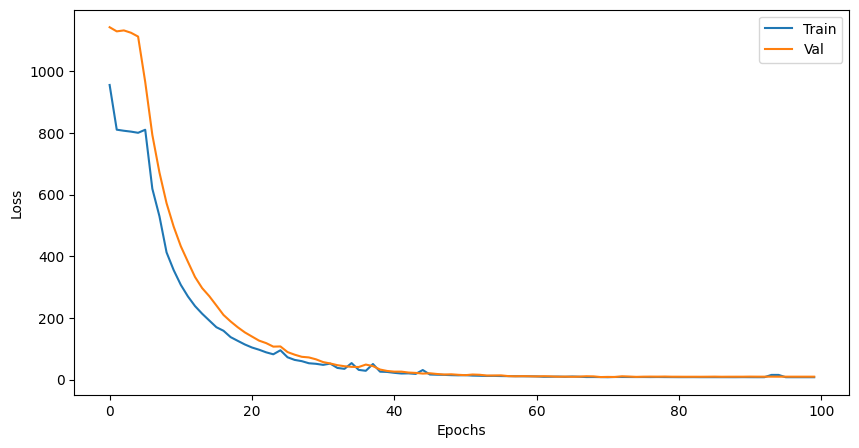

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses)
plt.plot(val_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'])

plt.show()

## D. Evaluating Your Trained Model

In [ ]:
# Load the trained weights
import torch.nn.functional as F
model.load_state_dict(torch.load('best_model.pth'))

# Set the model to evaluation mode
model.eval()

test_correct = 0
test_total = 0

pred_value = []
actual_value = []

with torch.no_grad():
    for features, labels in test_loader:
        features = features.cuda()
        outputs = model(features).squeeze(-1)
        pred_value.append(outputs.cpu())
        actual_value.append(labels)

pred_value = torch.cat(pred_value)
actual_value = torch.cat(actual_value)

test_loss = F.mse_loss(pred_value, actual_value)
#print(f'Actual Value:{actual_value}')
#print(f'Predict Value:{pred_value}')
print(f'Test MSE: {test_loss:.4f}')


Test MSE: 20.2622


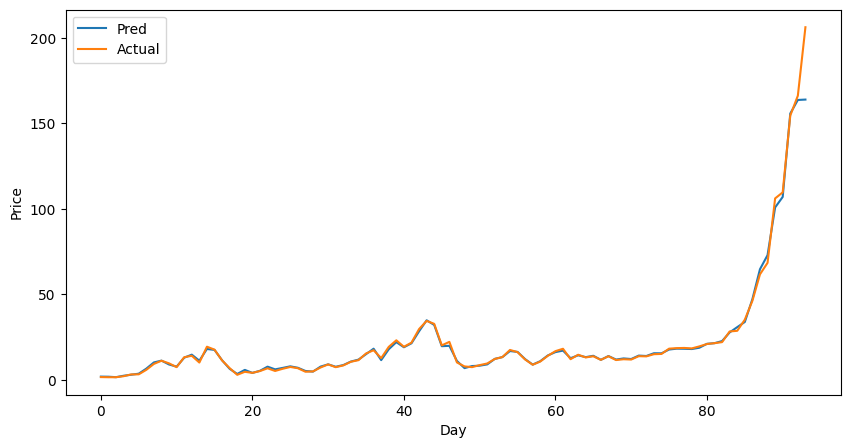

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(pred_value[:])
plt.plot(actual_value[:])
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend(['Pred', 'Actual'])

plt.show()

# (2) Feature Selection 實驗結果 (8 個 Scenario)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim # LSTM 隱藏層的維度
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True) # LSTM 模組
        self.fc = nn.Linear(hidden_dim, output_dim) # 線性層：將最後一層 LSTM 輸出轉為最終預測

    def forward(self, x):
        out, _ = self.lstm(x) # 將輸入 x 傳入 LSTM，得到時間序列的所有輸出
        out = self.fc(out[:, -1, :]) # 取最後一個時間步的輸出作為預測依據，接上線性層
        return out


# 建立時間序列的資料切片 (將原始表格資料切割成 LSTM 可以接受的序列格式)
def create_sequences(input_data, output_data, window_size, step): # window_size: 每筆輸入的時間長度（例如過去10天）; step: window每次滑動的步幅; input_data：特徵資料，例如 Open/High/Low/Close 等;output_data：標籤資料，這裡是下一天的 High
    sequences = []
    labels = []
    # 使用滑動視窗（sliding window）切割資料
    for i in range(0, len(input_data) - window_size, step):
        sequences.append(input_data[i:(i + window_size)]) # 從第 i 天開始，擷取連續 window_size 天的特徵資料當作一筆輸入
        labels.append(output_data[i + window_size]) # 第 i + window_size 天的 output_data 為該筆資料的標籤（預測目標）
    return np.array(sequences), np.array(labels)

# 跑實驗
def run_experiment(df, feature_list, window_size=10, step=5, hidden_dim=128, num_layers=2, batch_size=32, epochs=100):
    # 前處理
    df = df.dropna()
    features = df[feature_list].astype(float)
    labels = df['High'].shift(-1).astype(float)
    X, y = create_sequences(features.to_numpy(), labels.to_numpy(), window_size, step)

    # split the hold-out tests
    ind = np.linspace(0, len(X)-1, num=int(len(X)*0.1), dtype=int) # 10% hold-out
    x_test = X[ind]
    y_test = y[ind]
    all_ind = np.arange(len(X))
    remains_ind = np.delete(all_ind, ind)

    X = X[remains_ind]
    y = y[remains_ind]

    # shuffle dataset
    ind = np.random.permutation(len(X))
    X = X[ind]
    y = y[ind]
    split_point = int(X.shape[0]*0.8)

    x_train = X[:split_point]
    y_train = y[:split_point]
    x_val = X[split_point:]
    y_val = y[split_point:]

    # Convert to PyTorch tensors
    x_train = torch.from_numpy(x_train).float()
    y_train = torch.from_numpy(y_train).float()

    x_val = torch.from_numpy(x_val).float()
    y_val = torch.from_numpy(y_val).float()

    x_test = torch.from_numpy(x_test).float()
    y_test = torch.from_numpy(y_test).float()

    batch_size = 32

    # Create datasets
    train_dataset = TensorDataset(x_train, y_train)
    val_dataset = TensorDataset(x_val, y_val)
    test_dataset = TensorDataset(x_test, y_test)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    #print(f'Number of samples in training and validation are {len(train_loader.dataset)} and {len(val_loader.dataset)}.')

    train_losses = []
    val_losses = []

    epochs = 100

    model = LSTMModel(input_dim=x_train.shape[2], hidden_dim=500, num_layers=2, output_dim=1).cuda()
    #print(model)

    best_val_loss = float('inf')

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    lr_scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0)

    for epoch in tqdm(range(epochs)):
        # Training
        model.train()
        total_loss = 0.0

        for features, labels in train_loader:
            features = features.cuda()
            labels = labels.cuda()
            outputs = model(features).squeeze(-1)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Learning rate update
        lr_scheduler.step()

        avg_train_loss = total_loss / len(train_loader)

        # Validation
        model.eval()
        total_val_loss = 0.0

        with torch.no_grad():
            for features, labels in val_loader:
                features = features.cuda()
                labels = labels.cuda()
                outputs = model(features).squeeze(-1)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)

        # Checkpoint
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_model.pth')

        #print(f'Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Val loss: {avg_val_loss:.4f}, Best Val loss: {best_val_loss:.4f}')

        # Store performance
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)


    # 測試
    test_correct = 0
    test_total = 0

    pred_value = []
    actual_value = []

    with torch.no_grad():
        for features, labels in test_loader:
            features = features.cuda()
            outputs = model(features).squeeze(-1)
            pred_value.append(outputs.cpu())
            actual_value.append(labels)

    pred_value = torch.cat(pred_value)
    actual_value = torch.cat(actual_value)

    test_loss = criterion(pred_value, actual_value).item()
    print(f'Test MSE: {test_loss:.4f}')

    return test_loss

實驗組合 main()

In [ ]:
feature_sets = [
    ['Open', 'High', 'Low', 'Close'],
    ['Open', 'High', 'Low', 'Close','Volume'],
    ['Open', 'High', 'Low', 'Close', 'OpenInt'],
    ['Open', 'Low'],
    ['Open', 'High'],
    ['Open', 'High', 'Low'],
    ['Open', 'Close'],
    ['High', 'Low']
]

for i, features in enumerate(feature_sets):
    mse = run_experiment(df, features)
    print(f'Experiment {i+1}, Features: {features}, Test MSE: {mse:.4f}')

  0%|          | 0/100 [00:00<?, ?it/s]

Test MSE: 19.1997
Experiment 1, Features: ['Open', 'High', 'Low', 'Close'], Test MSE: 19.1997


  0%|          | 0/100 [00:00<?, ?it/s]

Test MSE: 1096.2781
Experiment 2, Features: ['Open', 'High', 'Low', 'Close', 'Volume'], Test MSE: 1096.2781


  0%|          | 0/100 [00:00<?, ?it/s]

Test MSE: 13.9858
Experiment 3, Features: ['Open', 'High', 'Low', 'Close', 'OpenInt'], Test MSE: 13.9858


  0%|          | 0/100 [00:00<?, ?it/s]

Test MSE: 22.5414
Experiment 4, Features: ['Open', 'Low'], Test MSE: 22.5414


  0%|          | 0/100 [00:00<?, ?it/s]

Test MSE: 24.0502
Experiment 5, Features: ['Open', 'High'], Test MSE: 24.0502


  0%|          | 0/100 [00:00<?, ?it/s]

Test MSE: 22.6784
Experiment 6, Features: ['Open', 'High', 'Low'], Test MSE: 22.6784


  0%|          | 0/100 [00:00<?, ?it/s]

Test MSE: 27.9799
Experiment 7, Features: ['Open', 'Close'], Test MSE: 27.9799


  0%|          | 0/100 [00:00<?, ?it/s]

Test MSE: 25.6523
Experiment 8, Features: ['High', 'Low'], Test MSE: 25.6523


# (3) 正規化前後之實驗結果

原版(無正規化)

Shape of data X: (945, 10, 4)
Shape of data y: (945,)
Shape of data x_train: (680, 10, 4)
Shape of data y_train: (680,)
Shape of data x_val: (171, 10, 4)
Shape of data y_val: (171,)
Shape of data x_test: (94, 10, 4)
Shape of data y_test: (94,)
Number of samples in training and validation are 680 and 171.
LSTMModel(
  (lstm): LSTM(4, 500, num_layers=2, batch_first=True)
  (fc): Linear(in_features=500, out_features=1, bias=True)
)


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100, Train loss: 959.5396, Val loss: 1001.1787, Best Val loss: 1001.1787
Epoch 2/100, Train loss: 880.2477, Val loss: 992.5227, Best Val loss: 992.5227
Epoch 3/100, Train loss: 988.7958, Val loss: 988.5798, Best Val loss: 988.5798
Epoch 4/100, Train loss: 849.0267, Val loss: 981.7549, Best Val loss: 981.7549
Epoch 5/100, Train loss: 789.3845, Val loss: 856.0609, Best Val loss: 856.0609
Epoch 6/100, Train loss: 654.6527, Val loss: 715.3233, Best Val loss: 715.3233
Epoch 7/100, Train loss: 544.4889, Val loss: 610.5674, Best Val loss: 610.5674
Epoch 8/100, Train loss: 601.0300, Val loss: 518.9354, Best Val loss: 518.9354
Epoch 9/100, Train loss: 388.6329, Val loss: 435.1723, Best Val loss: 435.1723
Epoch 10/100, Train loss: 418.2259, Val loss: 380.9197, Best Val loss: 380.9197
Epoch 11/100, Train loss: 287.6279, Val loss: 329.9557, Best Val loss: 329.9557
Epoch 12/100, Train loss: 251.8013, Val loss: 292.1248, Best Val loss: 292.1248
Epoch 13/100, Train loss: 223.4386, Val loss: 2

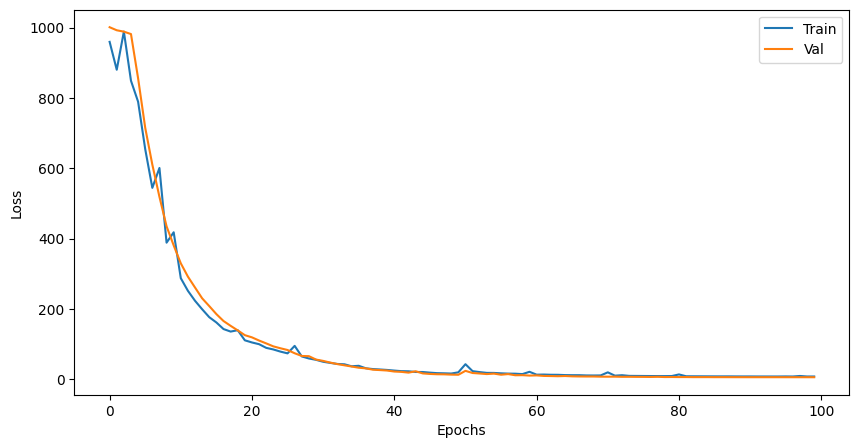

Test MSE: 20.8992


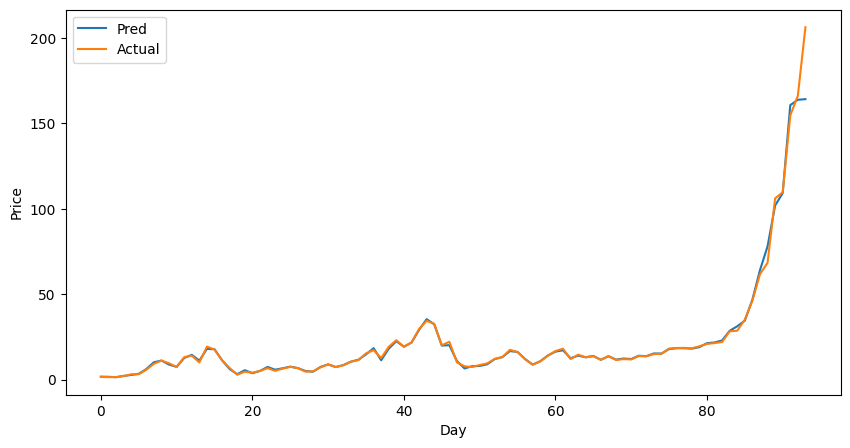

In [ ]:
import torch.nn.functional as F
#--------------------------------建立時間序列的資料切片 (將原始表格資料切割成 LSTM 可以接受的序列格式)-------------------------------#
def create_sequences(input_data, output_data, window_size, step): # window_size: 每筆輸入的時間長度（例如過去10天）; step: window每次滑動的步幅; input_data：特徵資料，例如 Open/High/Low/Close 等;output_data：標籤資料，這裡是下一天的 High
    sequences = []
    labels = []
    # 使用滑動視窗（sliding window）切割資料
    for i in range(0, len(input_data) - window_size, step):
        sequences.append(input_data[i:(i + window_size)]) # 從第 i 天開始，擷取連續 window_size 天的特徵資料當作一筆輸入
        labels.append(output_data[i + window_size]) # 第 i + window_size 天的 output_data 為該筆資料的標籤（預測目標）
    return np.array(sequences), np.array(labels)

#--------------------------------------------定義模型----------------------------------------#
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim # LSTM 隱藏層的維度
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True) # LSTM 模組
        self.fc = nn.Linear(hidden_dim, output_dim) # 線性層：將最後一層 LSTM 輸出轉為最終預測

    def forward(self, x):
        out, _ = self.lstm(x) # 將輸入 x 傳入 LSTM，得到時間序列的所有輸出
        out = self.fc(out[:, -1, :]) # 取最後一個時間步的輸出作為預測依據，接上線性層
        return out

#---------------------------------------特徵選擇與資料切割---------------------------------------------#
features = df[['Open', 'High', 'Low', 'Close']]
labels = df['High'].shift(-1) # shift(-1) 將 High 欄位往上平移一格
X, y = create_sequences(features, labels, window_size=10, step=5) # 將資料轉換為 LSTM 所需的序列格式。

print(f'Shape of data X: {X.shape}')
print(f'Shape of data y: {y.shape}')

# 切出測試集 split the hold-out tests
ind = np.linspace(0, len(X)-1, num=int(len(X)*0.1), dtype=int) # 使用等間距方式，從資料中選出 10% 當作測試集(hold-out)的索引
x_test = X[ind]
y_test = y[ind]
all_ind = np.arange(len(X))
remains_ind = np.delete(all_ind, ind) # 建立全體索引，再移除測試資料的索引，留下其餘作為 train/val

# X 與 y 變成「剩餘資料」
X = X[remains_ind]
y = y[remains_ind]

# 打亂資料，切分訓練與驗證集（Train 80% / Val 20%） shuffle dataset
ind = np.random.permutation(len(X))
X = X[ind]
y = y[ind]
split_point = int(X.shape[0]*0.8)

x_train = X[:split_point]
y_train = y[:split_point]
x_val = X[split_point:]
y_val = y[split_point:]

# 輸出所有子集的 shape，確保切割正確
print(f'Shape of data x_train: {x_train.shape}')
print(f'Shape of data y_train: {y_train.shape}')
print(f'Shape of data x_val: {x_val.shape}')
print(f'Shape of data y_val: {y_val.shape}')
print(f'Shape of data x_test: {x_test.shape}')
print(f'Shape of data y_test: {y_test.shape}')

# 將所有 numpy 陣列轉為 PyTorch Tensor 格式，並轉換為 float
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()

x_val = torch.from_numpy(x_val).float()
y_val = torch.from_numpy(y_val).float()

x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).float()

batch_size = 32

# 建立 Dataset 與 DataLoader
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
test_dataset = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f'Number of samples in training and validation are {len(train_loader.dataset)} and {len(val_loader.dataset)}.')

#-----------------------------------訓練主循環---------------------------------------#
train_losses = []
val_losses = []

epochs = 100

model = LSTMModel(input_dim=4, hidden_dim=500, num_layers=2, output_dim=1).cuda()
print(model)

best_val_loss = float('inf')

criterion = nn.MSELoss() # 定義損失函數為 MSE
optimizer = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0) # 餘弦學習率衰減調整器

for epoch in tqdm(range(epochs)):
    # Training
    model.train()
    total_loss = 0.0

    for features, labels in train_loader:
        features = features.cuda()
        labels = labels.cuda()
        outputs = model(features).squeeze(-1)
        loss = criterion(outputs, labels)
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Learning rate update
    lr_scheduler.step()

    avg_train_loss = total_loss / len(train_loader)

    # Validation
    model.eval()
    total_val_loss = 0.0

    with torch.no_grad(): # 驗證過程不計算梯度，加速運算
        for features, labels in val_loader:
            features = features.cuda()
            labels = labels.cuda()
            outputs = model(features).squeeze(-1)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)

    # Checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')

    print(f'Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Val loss: {avg_val_loss:.4f}, Best Val loss: {best_val_loss:.4f}')

    # Store performance
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

#-------------------------訓練過程可視化----------------------------#
plt.figure(figsize=(10, 5))
plt.plot(train_losses)
plt.plot(val_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'])
plt.show()

#----------------------------測試最佳模型------------------------------#
# Load the trained weights
model.load_state_dict(torch.load('best_model.pth'))

# Set the model to evaluation mode
model.eval()

test_correct = 0
test_total = 0

pred_value = []
actual_value = []

with torch.no_grad():
    for features, labels in test_loader:
        features = features.cuda()
        outputs = model(features).squeeze(-1)
        pred_value.append(outputs.cpu())
        actual_value.append(labels)

pred_value = torch.cat(pred_value)
actual_value = torch.cat(actual_value)

test_loss = F.mse_loss(pred_value, actual_value)

print(f'Test MSE: {test_loss:.4f}')

#------------------------------測試結果可視化--------------------------------#
plt.figure(figsize=(10, 5))
plt.plot(pred_value[:])
plt.plot(actual_value[:])
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend(['Pred', 'Actual'])

plt.show()

正規化的版本

Shape of data X: (946, 5, 4)
Shape of data y: (946,)
Shape of data x_train: (681, 5, 4)
Shape of data y_train: (681,)
Shape of data x_val: (171, 5, 4)
Shape of data y_val: (171,)
Shape of data x_test: (94, 5, 4)
Shape of data y_test: (94,)
Number of samples in training and validation are 681 and 171.
LSTMModel(
  (lstm): LSTM(4, 500, num_layers=2, batch_first=True)
  (fc): Linear(in_features=500, out_features=1, bias=True)
)


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100, Train loss: 987.5373, Val loss: 1104.9069, Best Val loss: 1104.9069
Epoch 2/100, Train loss: 845.1801, Val loss: 1003.2668, Best Val loss: 1003.2668
Epoch 3/100, Train loss: 728.9653, Val loss: 854.1718, Best Val loss: 854.1718
Epoch 4/100, Train loss: 615.6426, Val loss: 727.9697, Best Val loss: 727.9697
Epoch 5/100, Train loss: 510.8179, Val loss: 615.4776, Best Val loss: 615.4776
Epoch 6/100, Train loss: 487.0758, Val loss: 522.6679, Best Val loss: 522.6679
Epoch 7/100, Train loss: 369.6709, Val loss: 444.3773, Best Val loss: 444.3773
Epoch 8/100, Train loss: 414.8323, Val loss: 385.2973, Best Val loss: 385.2973
Epoch 9/100, Train loss: 281.3746, Val loss: 324.5409, Best Val loss: 324.5409
Epoch 10/100, Train loss: 241.7043, Val loss: 290.5403, Best Val loss: 290.5403
Epoch 11/100, Train loss: 211.8993, Val loss: 252.9436, Best Val loss: 252.9436
Epoch 12/100, Train loss: 192.0229, Val loss: 223.5091, Best Val loss: 223.5091
Epoch 13/100, Train loss: 202.0753, Val loss:

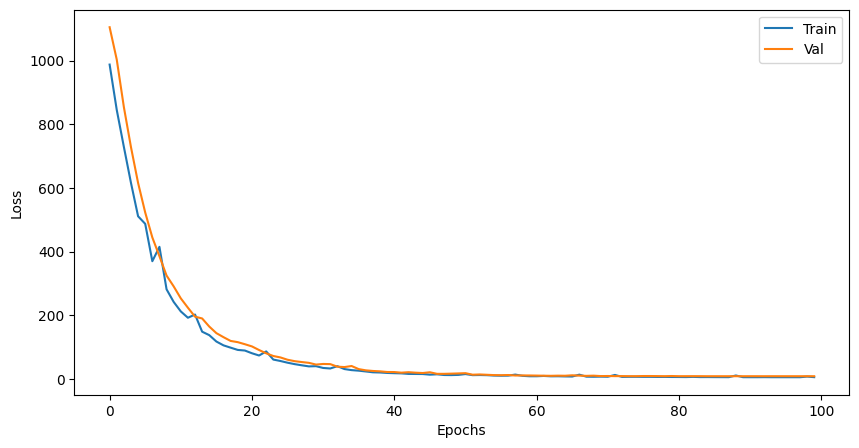

Test MSE: 15.5296


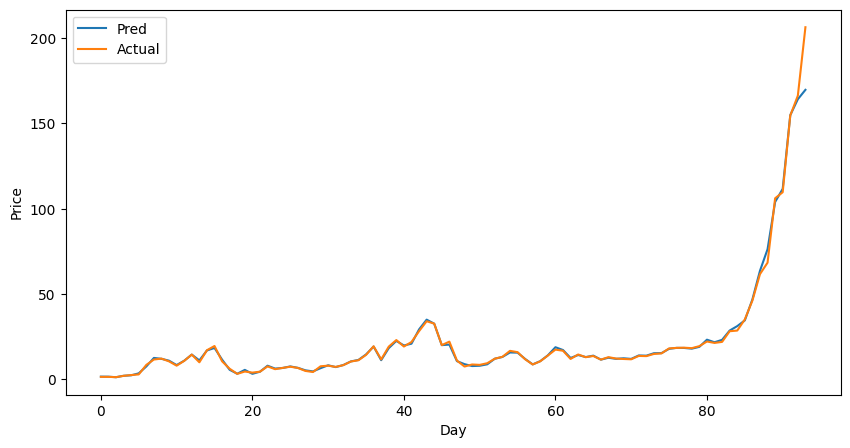

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import torch.nn.functional as F

#--------------------------------建立時間序列的資料切片 (將原始表格資料切割成 LSTM 可以接受的序列格式)-------------------------------#
def create_sequences(input_data, output_data, window_size, step): # window_size: 每筆輸入的時間長度（例如過去10天）; step: window每次滑動的步幅; input_data：特徵資料，例如 Open/High/Low/Close 等;output_data：標籤資料，這裡是下一天的 High
    sequences = []
    labels = []
    # 使用滑動視窗（sliding window）切割資料
    for i in range(0, len(input_data) - window_size, step):
        sequences.append(input_data[i:(i + window_size)]) # 從第 i 天開始，擷取連續 window_size 天的特徵資料當作一筆輸入
        labels.append(output_data[i + window_size]) # 第 i + window_size 天的 output_data 為該筆資料的標籤（預測目標）
    return np.array(sequences), np.array(labels)

#--------------------------------------------定義模型----------------------------------------#
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim # LSTM 隱藏層的維度
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True) # LSTM 模組
        self.fc = nn.Linear(hidden_dim, output_dim) # 線性層：將最後一層 LSTM 輸出轉為最終預測

    def forward(self, x):
        out, _ = self.lstm(x) # 將輸入 x 傳入 LSTM，得到時間序列的所有輸出
        out = self.fc(out[:, -1, :]) # 取最後一個時間步的輸出作為預測依據，接上線性層
        return out

#---------------------------------------特徵選擇與資料切割---------------------------------------------#

#---------------- 正規化 ----------------------#
# Select features
features = df[['Open', 'High', 'Low', 'Close']]
# features = df[['Open', 'High', 'Low', 'Close', 'Volume']]
labels = df['High'].shift(-1)  # Next day's high price as label

# Initialize scaler
feature_scaler = MinMaxScaler()
label_scaler = MinMaxScaler()

# Fit and transform features
features_scaled = feature_scaler.fit_transform(features)

# Fit and transform labels (labels 也要正規化喔，因為是回歸問題)
labels_scaled = label_scaler.fit_transform(labels.values.reshape(-1, 1))

# 將 numpy 轉回 tensor
import torch

features_tensor = torch.tensor(features_scaled, dtype=torch.float32)
labels_tensor = torch.tensor(labels_scaled.squeeze(), dtype=torch.float32)

X, y = create_sequences(features, labels, window_size=5, step=5) # 將資料轉換為 LSTM 所需的序列格式。

print(f'Shape of data X: {X.shape}')
print(f'Shape of data y: {y.shape}')

# 切出測試集 split the hold-out tests
ind = np.linspace(0, len(X)-1, num=int(len(X)*0.1), dtype=int) # 使用等間距方式，從資料中選出 10% 當作測試集(hold-out)的索引
x_test = X[ind]
y_test = y[ind]
all_ind = np.arange(len(X))
remains_ind = np.delete(all_ind, ind) # 建立全體索引，再移除測試資料的索引，留下其餘作為 train/val

# X 與 y 變成「剩餘資料」
X = X[remains_ind]
y = y[remains_ind]

# 打亂資料，切分訓練與驗證集（Train 80% / Val 20%） shuffle dataset
ind = np.random.permutation(len(X))
X = X[ind]
y = y[ind]
split_point = int(X.shape[0]*0.8)

x_train = X[:split_point]
y_train = y[:split_point]
x_val = X[split_point:]
y_val = y[split_point:]

# 輸出所有子集的 shape，確保切割正確
print(f'Shape of data x_train: {x_train.shape}')
print(f'Shape of data y_train: {y_train.shape}')
print(f'Shape of data x_val: {x_val.shape}')
print(f'Shape of data y_val: {y_val.shape}')
print(f'Shape of data x_test: {x_test.shape}')
print(f'Shape of data y_test: {y_test.shape}')

# 將所有 numpy 陣列轉為 PyTorch Tensor 格式，並轉換為 float
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()

x_val = torch.from_numpy(x_val).float()
y_val = torch.from_numpy(y_val).float()

x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).float()

batch_size = 32

# 建立 Dataset 與 DataLoader
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
test_dataset = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f'Number of samples in training and validation are {len(train_loader.dataset)} and {len(val_loader.dataset)}.')

#-----------------------------------訓練主循環---------------------------------------#
train_losses = []
val_losses = []

epochs = 100

model = LSTMModel(input_dim=4, hidden_dim=500, num_layers=2, output_dim=1).cuda()
print(model)

best_val_loss = float('inf')

criterion = nn.MSELoss() # 定義損失函數為 MSE
optimizer = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0) # 餘弦學習率衰減調整器

for epoch in tqdm(range(epochs)):
    # Training
    model.train()
    total_loss = 0.0

    for features, labels in train_loader:
        features = features.cuda()
        labels = labels.cuda()
        outputs = model(features).squeeze(-1)
        loss = criterion(outputs, labels)
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Learning rate update
    lr_scheduler.step()

    avg_train_loss = total_loss / len(train_loader)

    # Validation
    model.eval()
    total_val_loss = 0.0

    with torch.no_grad(): # 驗證過程不計算梯度，加速運算
        for features, labels in val_loader:
            features = features.cuda()
            labels = labels.cuda()
            outputs = model(features).squeeze(-1)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)

    # Checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')

    print(f'Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Val loss: {avg_val_loss:.4f}, Best Val loss: {best_val_loss:.4f}')

    # Store performance
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

#-------------------------訓練過程可視化----------------------------#
plt.figure(figsize=(10, 5))
plt.plot(train_losses)
plt.plot(val_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'])
plt.show()

#----------------------------測試最佳模型------------------------------#
# Load the trained weights
model.load_state_dict(torch.load('best_model.pth'))

# Set the model to evaluation mode
model.eval()

test_correct = 0
test_total = 0

pred_value = []
actual_value = []

with torch.no_grad():
    for features, labels in test_loader:
        features = features.cuda()
        outputs = model(features).squeeze(-1)
        pred_value.append(outputs.cpu())
        actual_value.append(labels)

pred_value = torch.cat(pred_value)
actual_value = torch.cat(actual_value)

test_loss = F.mse_loss(pred_value, actual_value)
print(f'Test MSE: {test_loss:.4f}')

#------------------------------測試結果可視化--------------------------------#
plt.figure(figsize=(10, 5))
plt.plot(pred_value[:])
plt.plot(actual_value[:])
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend(['Pred', 'Actual'])

plt.show()